In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
random.shuffle(words)
words[:8]

['cesirio',
 'danilla',
 'gogliardo',
 'manlia',
 'tullio',
 'orida',
 'michelangiolo',
 'veneto']

In [3]:
words = [w for w in words if not ',' in w and not '.' in w and w != "nicolo'" and len(w) >= 3]

In [4]:
min(len(w) for w in words), max(len(w) for w in words)

(3, 27)

In [5]:
len(words)

9111

In [6]:
for i in range(len(words)):
    if "‡" in words[i]:
        words[i] = words[i][:-1] + "a'"
    if "˘" in words[i]:
        words[i] = words[i][:-1] + "u'"
    if "Ú" in words[i]:
        words[i] = words[i][:-1] + "o'"
    if "Ï" in words[i]:
        words[i] = words[i][:-1] + "i'"
    if "Ë" in words[i]:
        words[i] = words[i][:-1] + "e'"

In [7]:
# for word in words:
#     if len(word) == 5:
#         print(word)

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
voc_len = len(itos)
print(itos)

{1: ' ', 2: "'", 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 0: '.'}


0-th order names generator (i.e. random guessing)

In [9]:
g = torch.Generator().manual_seed(0)

for i in range(5):
    out = []
    while True:
        p = torch.ones(voc_len)
        p /= p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

zrkxptchnfkchpkjicqtdqamdnoqsdupcbkxnkuhe sgmkw zwteczthns.
nn bzobiwautuir.
ecblbdihcimoimcjvx rcccqobzqnjzlzwdrjmbq ljufgr w wfp 'rakwfadslmatpq'ne'tp'xtqnrimxpgvthwqzd.
l'foylofrpcftbceizafwntg'oksxvqnapvmsibxidczffbigwzbcdicgzhdt'wenxsfinscrokaazhpmf.
ieuvw.


1-th order names generator: using the average char occurence

In [10]:
N = torch.zeros(voc_len, dtype=torch.int32)
for w in words:
    chs = list(w) + ['.']
    for ch in chs:
        ix = stoi[ch]
        N[ix] += 1

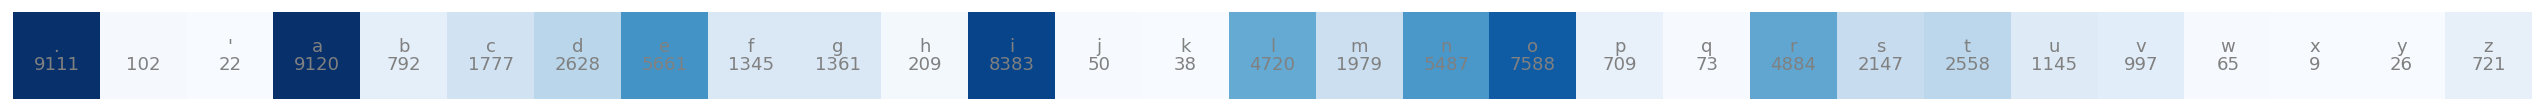

In [11]:
plt.figure(figsize=(25, 1), dpi=130)
plt.imshow(N[None], cmap='Blues')
for i in range(voc_len):
        chstr = itos[i]
        plt.text(i, 0, chstr, ha="center", va="bottom", color='gray')
        plt.text(i, 0, N[i].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [12]:
g = torch.Generator().manual_seed(0)

P = N.float()
P /= P.sum()

for i in range(10):
    out = []
    while True:
        ix = torch.multinomial(P, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

unisnoaeldiaemiifanoan.
iallnoaomaaislioec.
oeiir.
zrobavoelo.
ll.
azlaer.
ooofo.
baaiaafeafileiagrs.
naaanmavnliuiuraniian.
iioden.


2-nd order names generator: using two points correlations

In [13]:
N = torch.zeros((voc_len, voc_len), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

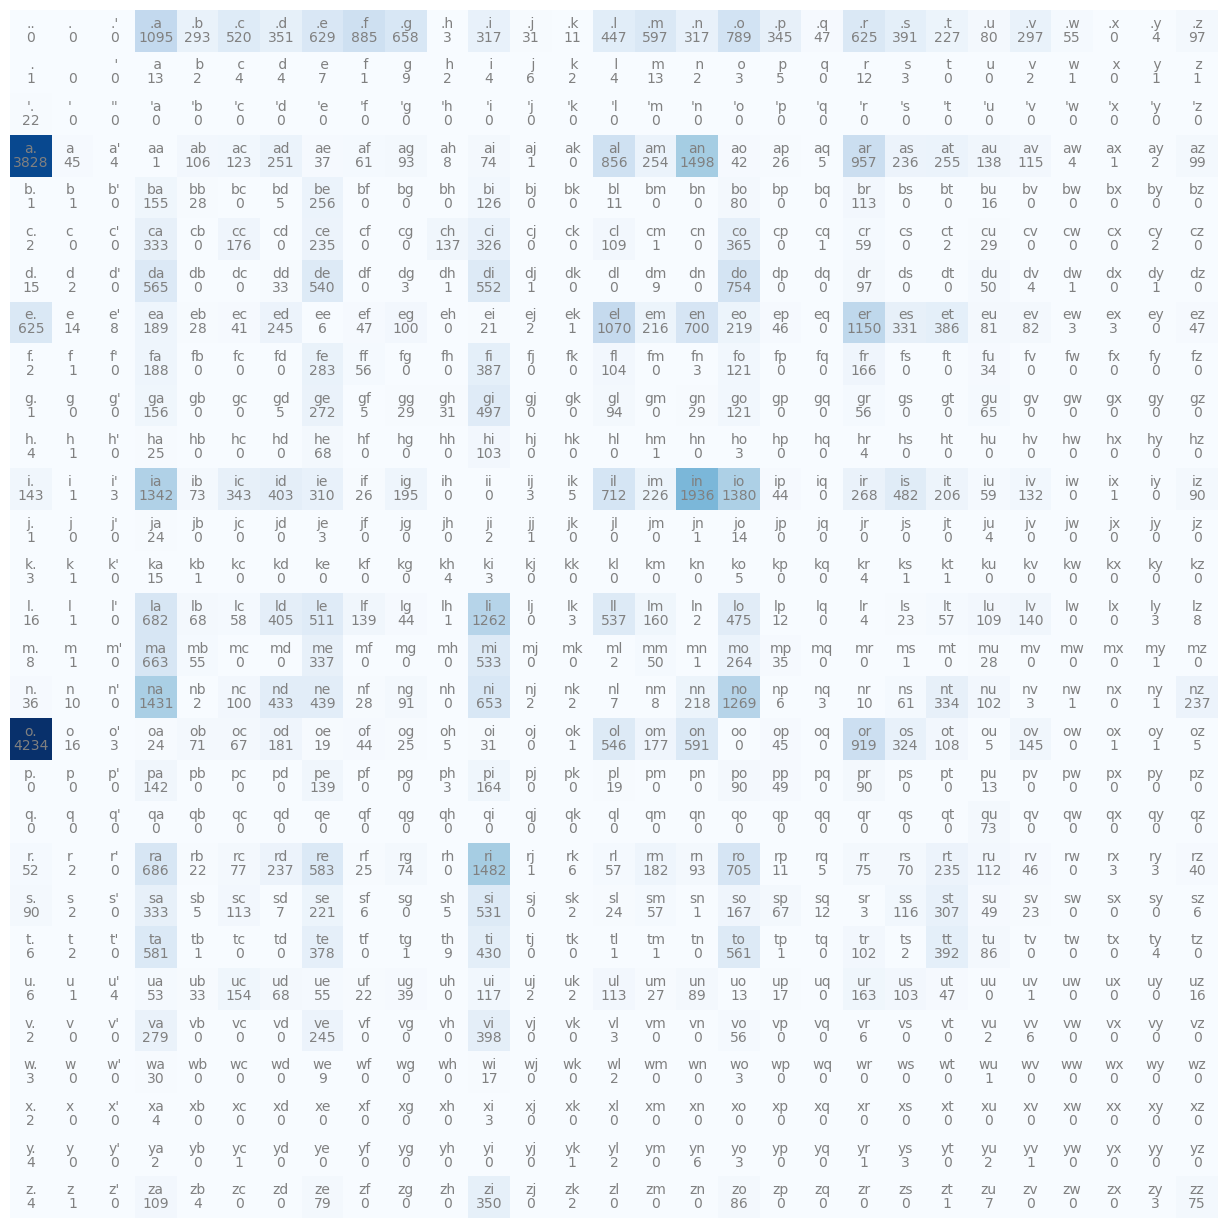

In [14]:
plt.figure(figsize=(16,16), dpi=100)
plt.imshow(N, cmap='Blues')
for i in range(voc_len):
    for j in range(voc_len):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [15]:
P = N.float()
P /= P.sum(1, keepdims=True)

g = torch.Generator().manual_seed(0)

for i in range(10):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

vintona.
mada.
memefio.
o.
jalino.
ricaeto.
pelandinquzona.
wilio.
mia.
zia.


3-rd order names generator: using three-point correlations

In [17]:
N = torch.zeros((voc_len, voc_len, voc_len), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1

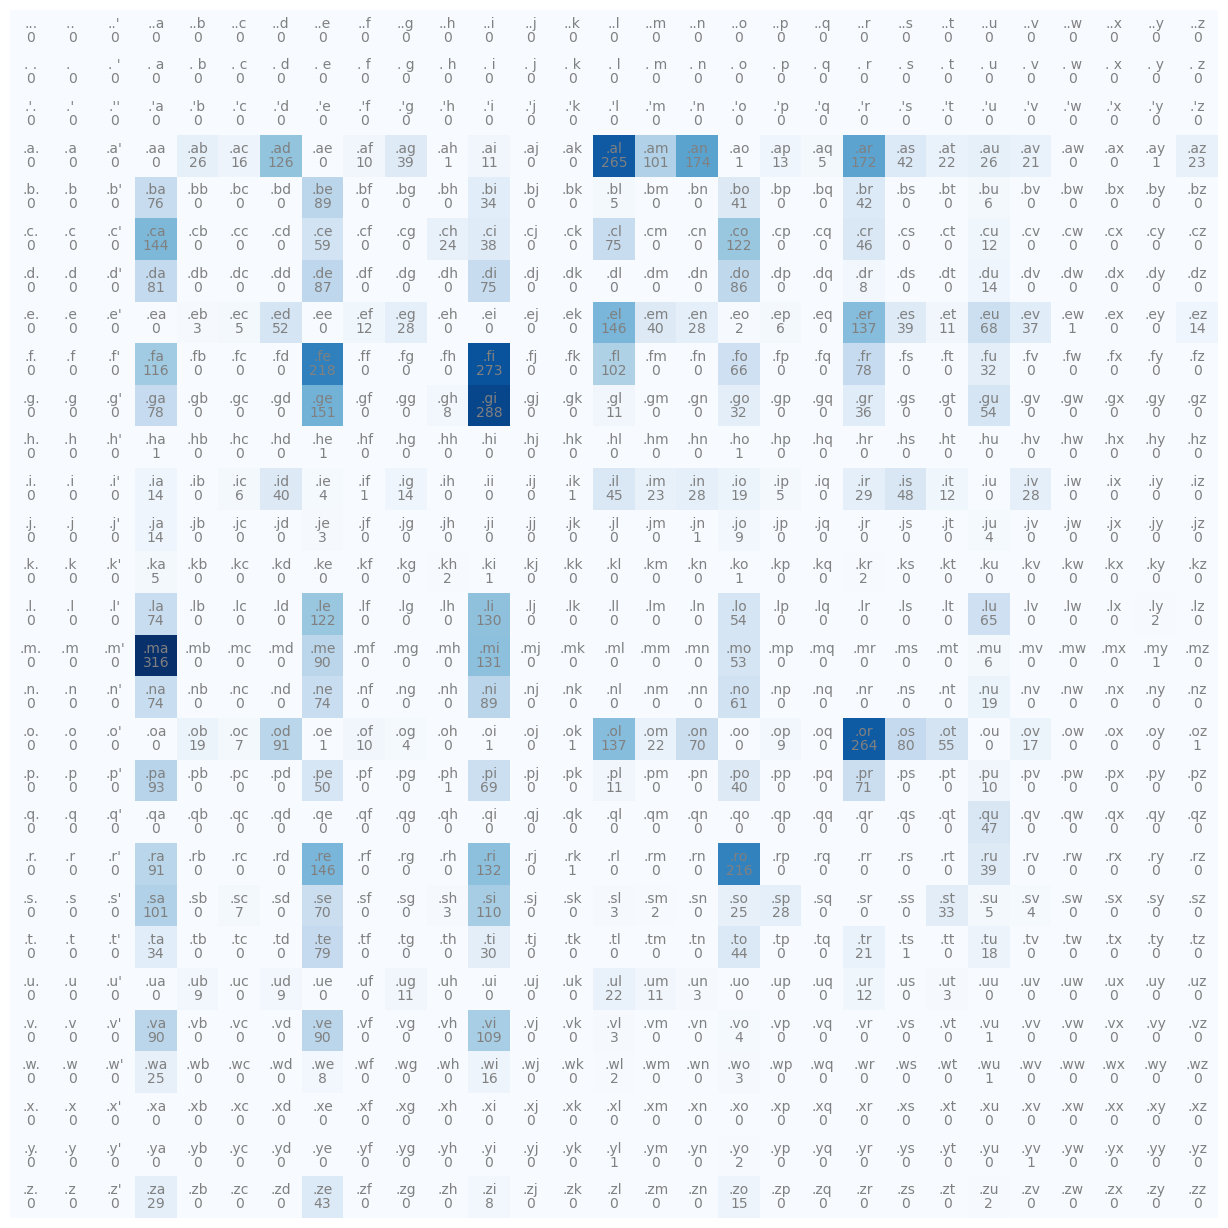

In [21]:
# check words beginnings
plt.figure(figsize=(16,16), dpi=100)
k = 0
plt.imshow(N[k], cmap='Blues')
for i in range(voc_len):
    for j in range(voc_len):
        chstr = itos[k] + itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[k, i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

TODO: implement, using two points correlations to start?
Or just sum away one row.

In [15]:
P = N.float()
P /= P.sum(1, keepdims=True)

g = torch.Generator().manual_seed(0)

for i in range(10):
    out = []
    ix1 = 0
    p = P[ix1].sum(-1)
    ix2 
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

vintona.
mada.
memefio.
o.
jalino.
ricaeto.
pelandinquzona.
wilio.
mia.
zia.
